In [ ]:
from google.colab import drive
import zipfile
import pandas as pd
# Mount Google Drive
# drive.mount('/content/drive')

data_file_path = 'btcusdt_15m.csv'

# Define the extraction directory

# extracted_dir = '/content/drive/MyDrive/extracted'

#  Unzip the file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extracted_dir)

# List the contents of the extraction directory
# extracted_files = zip_ref.namelist()
# print("Extracted files:", extracted_files)

# Assuming there's a CSV file in the extracted directory
# Specify the number of rows you want to load (replace n with the actual number)

# n = 30000
# start_row = 340000
# end_row = 369314
# Load the first n rows from the CSV file into a DataFrame
# csv_file_path =  pd.read_csv(data_file_path,nrows=n) #,
csv_file_path = pd.read_csv(data_file_path)#, skiprows=range(1, start_row), nrows=end_row - start_row + 1

# Read the CSV file into a DataFrame
data = csv_file_path
print(data.columns)
# Display the first few rows of the DataFrame
print(data)


Index(['datetime', 'open', 'high', 'low', 'close', 'volume'], dtype='object')
                  datetime      open      high       low     close      volume
0      2018-01-01 05:30:00  13715.65  13715.65  13400.01  13556.15  123.616013
1      2018-01-01 05:45:00  13533.75  13550.87  13402.00  13521.12   98.136430
2      2018-01-01 06:00:00  13500.00  13545.37  13450.00  13470.41   79.904037
3      2018-01-01 06:15:00  13494.65  13690.87  13450.00  13529.01  141.699719
4      2018-01-01 06:30:00  13528.99  13571.74  13402.28  13445.63   72.537533
...                    ...       ...       ...       ...       ...         ...
57808  2019-08-30 04:00:00   9489.33   9496.19   9472.30   9486.17   79.386416
57809  2019-08-30 04:15:00   9482.00   9503.76   9477.34   9478.51  129.235238
57810  2019-08-30 04:30:00   9480.78   9486.21   9450.00   9450.00  214.710693
57811  2019-08-30 04:45:00   9450.15   9509.00   9447.11   9501.76  230.188942
57812  2019-08-30 05:00:00    950.00       NaN       

In [ ]:

import numpy as np
import pandas as pd
import yfinance as yf #added to verify indicators please remove as needed

# data #add crypto data
# period #add period

#EMA
def calculate_ema(data, period):
       ema = np.zeros_like(data)
       multiplier = 2 / (period + 1)
       ema[period - 1] = np.mean(data[:period])
       for i in range(period, len(data)):
           ema[i] = (data[i] - ema[i - 1]) * multiplier + ema[i - 1]
       return ema

#ATR
def calculate_atr(high, low, close, period):
       tr = np.maximum(high - low, np.maximum(np.abs(high - close[1:]), np.abs(low - close[1:])))
       atr = np.zeros_like(close)
       atr[period - 1] = np.mean(tr[:period])
       for i in range(period, len(close)):
           atr[i] = (atr[i - 1] * (period - 1) + tr[i]) / period
       return atr


#Ichimoku Cloud

def ichimoku_cloud(high,low,close,tenkan_sen, kijun_sen):

   def calculate_tenkan_sen(high, low):
       tenkan_sen = (np.max(high[:9]) + np.min(low[:9])) / 2
       return tenkan_sen

   def calculate_kijun_sen(high, low):
       kijun_sen = (np.max(high[:26]) + np.min(low[:26])) / 2
       return kijun_sen

   def calculate_senkou_span_a(tenkan_sen, kijun_sen):
       return (tenkan_sen + kijun_sen) / 2

   def calculate_senkou_span_b(high, low):
       return (np.max(high[:52]) + np.min(low[:52])) / 2

   def calculate_chikou_span(close):
       return np.roll(close, -26)

   calculate_tenkan_sen(high, low), calculate_kijun_sen(high, low), calculate_senkou_span_a(tenkan_sen, kijun_sen), calculate_senkou_span_b(high, low), calculate_chikou_span(close)

#Supertrend
def calculate_supertrend(high, low, close, multiplier, period):
    atr = calculate_atr(high, low, close, period)
    basic_upper_band = (high + low) / 2 + multiplier * atr
    basic_lower_band = (high + low) / 2 - multiplier * atr

    final_upper_band = np.copy(basic_upper_band)
    final_lower_band = np.copy(basic_lower_band)

    for i in range(period, len(close)):
        if close[i - 1] > final_upper_band[i - 1]:
            final_upper_band[i] = min(basic_upper_band[i], final_upper_band[i - 1])
        else:
            final_upper_band[i] = basic_upper_band[i]

        if close[i - 1] < final_lower_band[i - 1]:
            final_lower_band[i] = max(basic_lower_band[i], final_lower_band[i - 1])
        else:
            final_lower_band[i] = basic_lower_band[i]

    return final_upper_band, final_lower_band

#Binance Bollinger Bands
def calculate_binance_bollinger_bands(close, period, std_dev):
       sma = calculate_sma(close, period)
       std = np.std(close[-period:], ddof=0)
       upper_band = sma + std_dev * std
       lower_band = sma - std_dev * std
       return upper_band, sma, lower_band

#On Balance Volume (OBV)
def calculate_obv(close, volume):
       obv = np.zeros_like(close)
       obv[0] = 0
       for i in range(1, len(close)):
           if close[i] > close[i - 1]:
               obv[i] = obv[i - 1] + volume[i]
           elif close[i] < close[i - 1]:
               obv[i] = obv[i - 1] - volume[i]
           else:
               obv[i] = obv[i - 1]
       return obv

#Money Flow Index (MFI)
def calculate_mfi(high, low, close, volume, period):
       typical_price = (high + low + close) / 3
       raw_money_flow = typical_price * volume
       money_flow_ratio = np.where(typical_price > np.roll(typical_price, 1), raw_money_flow, 0)
       positive_money_flow = np.sum(money_flow_ratio[-period:], where=money_flow_ratio[-period:] > 0)
       negative_money_flow = -np.sum(money_flow_ratio[-period:], where=money_flow_ratio[-period:] < 0)
       money_flow_index = 100 - (100 / (1 + (positive_money_flow / negative_money_flow)))
       return money_flow_index

#Fibonacci Retracement Levels
def calculate_fibonacci_levels(low, high):
       retracement_0 = high
       retracement_100 = low
       retracement_38 = retracement_100 + (0.382 * (retracement_0 - retracement_100))
       retracement_50 = retracement_100 + (0.5 * (retracement_0 - retracement_100))
       retracement_61 = retracement_100 + (0.618 * (retracement_0 - retracement_100))
       return retracement_38, retracement_50, retracement_61

#RSI
def calculate_rsi(data, column_name='close', window=14):
    delta = data[column_name].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

def calculate_sma(data, period):
    """
    Calculate Simple Moving Average (SMA).

    Parameters:
    - data: numpy array or list of numerical values.
    - period: integer, the number of periods to consider for the average.

    Returns:
    - sma: numpy array, the calculated SMA values.
    """
    sma = np.zeros_like(data)
    for i in range(period - 1, len(data)):
        sma[i] = np.mean(data[i - period + 1 : i + 1])
    return sma


In [ ]:
def execute_trade(data):
    ema_period = 9
    atr_period = 11
    supertrend_multiplier = 1.5
    supertrend_period = 11

    # Calculate RSI
    rsi_values = calculate_rsi(data)
    data['RSI'] = rsi_values

    # Calculate other technical indicators
    data['EMA'] = calculate_ema(data['close'], ema_period)
    data['ATR'] = calculate_atr(data['high'], data['low'], data['close'], atr_period)
    data['SuperTrendUpper'], data['SuperTrendLower'] = calculate_supertrend(data['high'], data['low'], data['close'], supertrend_multiplier, supertrend_period)

    # Calculate MACD
    short_ema = calculate_ema(data['close'], 12)
    long_ema = calculate_ema(data['close'], 26)
    data['MACD'] = short_ema - long_ema
    data['SignalLine'] = calculate_ema(data['MACD'], 9)

    ichimoku_cloud(data['high'], data['low'], data['close'],15 , 30)
    calculate_kijun_sen(data['high'], data['low'])
    calculate_tenkan_sen(data['high'], data['low'])

    # Initialize signals
    signals = np.zeros(len(data))

    # Combine conditions for RSI, SuperTrend, EMA, and MACD
    for i in range(1, len(data)):
        if (
            data['RSI'][i] > 85
            and calculate_kijun_sen(data['high'], data['low']) > calculate_tenkan_sen(data['high'], data['low'])
        ):
            signals[i] = 1  # Buy signal
        elif (
            data['RSI'][i] < 30
            and calculate_kijun_sen(data['high'], data['low']) < calculate_tenkan_sen(data['high'], data['low'])
        ):
            signals[i] = -1  # Sell signal

    return signals



In [ ]:


buying_price_col = []
buying_time_col = []
selling_price_col = []
selling_time_col = []

def simulate_trades(data, initial_balance=10000):
    balance = initial_balance
    position = 0  # 1 for long (buy), -1 for short (sell), 0 for no position
    holdings = 0  # Number of coins held
    balance_history = []
    buying_price = 0


    for i in range(len(data)):
        if data['TradeSignal'][i] == 1 and position != 1:


            position = 1
            # print(position, balance)
            buying_price_col.append(data['close'][i])
            buying_time_col.append(data['datetime'][i])
            buying_price = data['close'][i]
            holdings = balance / data['close'][i]
            balance -= holdings * data['close'][i]
            #print(holdings)



        elif data['TradeSignal'][i] == -1 and position != -1  and position != 0 :  # Sell signal or data['close'][i] < .95* buying_price and data['close'][i]>buying_price_col[len(buying_price_col)-1]
            position = -1
            #print(holdings)
            selling_price_col.append(data['close'][i])
            selling_time_col.append(data['datetime'][i])
            balance += holdings * data['close'][i]
            holdings = 0
            # print(position, balance)



        balance_history.append(balance + holdings * data['close'][i])

    print(balance_history[len(balance_history) - 1])
    return balance_history




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

crypto_data = data

# Execute trades
trade_signals = execute_trade(crypto_data)

crypto_data['TradeSignal'] = trade_signals

# Simulate trades
balance_history = simulate_trades(crypto_data)

# Add the balance history to the DataFrame
crypto_data['Balance'] = balance_history
display(crypto_data['Balance'])
# Plot the balance over time

number_of_trades = 0
number_of_trades = len(selling_price_col)

# for i in range(len(crypto_data)):
#     #  if crypto_data['TradeSignal'][i]==1:
#     #   print(crypto_data['TradeSignal'][i], crypto_data['close'][i],crypto_data['RSI'][i])
#     #  elif crypto_data['TradeSignal'][i]==-1:
#     #   print(crypto_data['TradeSignal'][i],crypto_data['close'][i],crypto_data['RSI'][i])\
#     print(crypto_data['TradeSignal'][i])
# Plot the first set of data
max(crypto_data['Balance'])
# print(len(crypto_data['Balance']))




nan


0        10000.000000
1        10000.000000
2        10000.000000
3        10000.000000
4        10000.000000
             ...     
57808    21075.550314
57809    21075.550314
57810    21075.550314
57811    21075.550314
57812             NaN
Name: Balance, Length: 57813, dtype: float64

32277.7279062436

<class 'pandas.core.series.Series'>


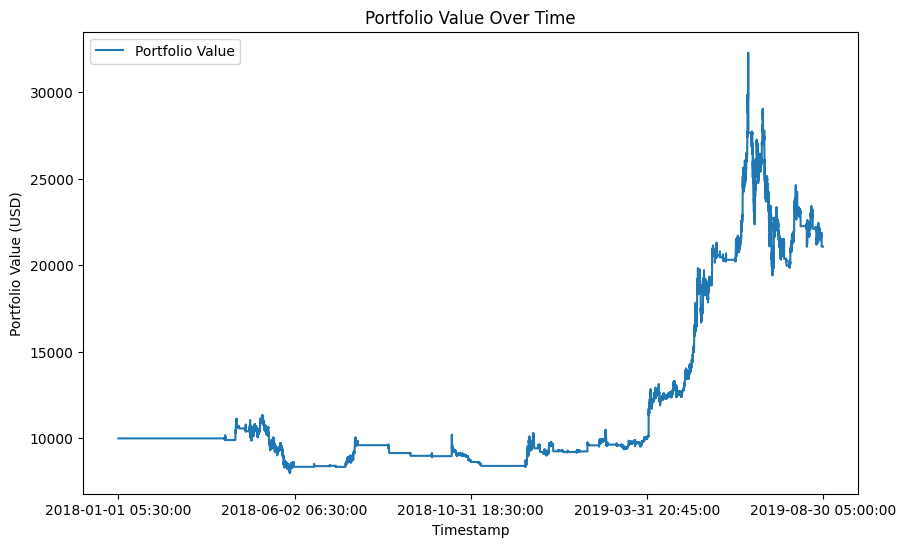

In [ ]:
# Assuming crypto_data['datetime'] is a pandas datetime column
x_values = crypto_data['datetime']
y_values = crypto_data['Balance']
print(type(crypto_data['datetime']))
# Get 100 equally spaced indices
indices = np.linspace(0, len(x_values) - 1, 5, dtype=int)

plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, label='Portfolio Value')

# Set xticks with 100 values at equal intervals
plt.xticks(x_values[indices])


plt.title('Portfolio Value Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Portfolio Value (USD)')
plt.legend()
plt.show()
plt.close()


